In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas import DataFrame, Series
import torch
from tqdm import tqdm

In [2]:
train_stat = pd.read_csv('./sep_data/train_stat_feat_df.csv')
dev_stat = pd.read_csv('./sep_data/dev_stat_feat_df.csv')

dev_stat.head()

,tweet_id,reply_reply_count,reply_like_count,reply_retweet_count,reply_quote_count,reply_possibly_sensitive,reply_has_url,reply_mentioned_url_num,reply_id_num,reply_isweekday,...,quote_count,possibly_sensitive,has_url,mentioned_url_num,id_num,isweekday,followers_count,tweet_count,verified,senti_score
0,1249004694950817796,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.004405,0.000000,0.001066,0.000000,...,0.0,0.0,1.0,0.333333,0.000000,0.0,0.000557,0.051326,0.0,1.0
1,1267552274819227649,0.000048,0.000000e+00,0.000000,0.000000,0.0,0.008811,0.000000,0.004264,0.012048,...,0.0,0.0,1.0,0.000000,0.020408,1.0,0.000012,0.011393,0.0,0.0
2,1235238334722699265,0.000215,1.959079e-06,0.000007,0.000024,0.0,0.013216,0.000000,0.000000,0.060241,...,0.0,0.0,0.0,0.000000,0.000000,1.0,0.000048,0.088659,0.0,0.0
3,1248746792914546688,0.000000,6.530263e-07,0.000000,0.000000,0.0,0.004405,0.000000,0.001066,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,1.0,0.000015,0.013806,0.0,0.0
4,523820806917603328,0.000119,1.306053e-06,0.000004,0.000000,0.0,0.114537,0.054348,0.062900,0.024096,...,0.0,0.0,1.0,0.666667,0.020408,0.0,0.021542,0.037443,1.0,0.0


In [3]:
train_tweet = pd.read_csv('./sep_data/train_tweet_df.csv')
dev_tweet = pd.read_csv('./sep_data/dev_tweet_df.csv')

dev_tweet.head()

,tweet_id,text,created_at,user_id,tweet_id.1,label,reply,reply_text
0,1249004694950817796,covid fact hand dryer effect kill new coronavi...,2020-04-11T16:01:39.000Z,35761403,1249004694950817796,0,1249011200068730880,fact germ breed [SEP]
1,1267552274819227649,expect result husband pend antibodi test pleas...,2020-06-01T20:23:06.000Z,2734457193,1267552274819227649,0,"1270394169836568576,1270502071175909376",hi luck boat [SEP]
2,1235238334722699265,covid spread peopl catch covid other diseas sp...,2020-03-04T16:19:03.000Z,53980699,1235238334722699265,0,"1235234904281165825,1235234927937048577,123523...",read lot corona viru late think share highligh...
3,1248746792914546688,everi news outlet use headlin like antibiot ef...,2020-04-10T22:56:50.000Z,393187879,1248746792914546688,0,1248775858120097792,appar headlin question answer usual [SEP]
4,523820806917603328,research encount goliath birdeat world largest...,2014-10-19T12:59:47.000Z,39585367,523820806917603328,0,"523821510042353664,523822210071658496,52382235...",eu tenho uma dessa em casa são ótima para coça...


### Fill NaN

In [4]:
dev_tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522 entries, 0 to 521
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_id    522 non-null    int64 
 1   text        522 non-null    object
 2   created_at  522 non-null    object
 3   user_id     522 non-null    int64 
 4   tweet_id.1  522 non-null    int64 
 5   label       522 non-null    int64 
 6   reply       522 non-null    object
 7   reply_text  518 non-null    object
dtypes: int64(4), object(4)
memory usage: 32.8+ KB


In [5]:
train_tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1542 entries, 0 to 1541
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_id    1542 non-null   int64 
 1   text        1542 non-null   object
 2   created_at  1542 non-null   object
 3   user_id     1542 non-null   int64 
 4   tweet_id.1  1542 non-null   int64 
 5   label       1542 non-null   int64 
 6   reply       1542 non-null   object
 7   reply_text  1532 non-null   object
dtypes: int64(4), object(4)
memory usage: 96.5+ KB


In [6]:
dev_tweet.reply_text.fillna('', inplace=True)
train_tweet.reply_text.fillna('', inplace=True)

In [7]:
dev_tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522 entries, 0 to 521
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_id    522 non-null    int64 
 1   text        522 non-null    object
 2   created_at  522 non-null    object
 3   user_id     522 non-null    int64 
 4   tweet_id.1  522 non-null    int64 
 5   label       522 non-null    int64 
 6   reply       522 non-null    object
 7   reply_text  522 non-null    object
dtypes: int64(4), object(4)
memory usage: 32.8+ KB


### Get Embeddings

In [8]:
for i in tqdm(range(len(dev_tweet))):
    dev_tweet.text.iloc[i] = '[CLS] ' + str(dev_tweet.text.iloc[i]).strip() + ' [SEP] ' + str(dev_tweet.reply_text.iloc[i]).strip()

  0%|                                                                                          | 0/522 [00:00<?, ?it/s]C:\Users\trist\AppData\Local\Temp\ipykernel_18288\1498738565.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev_tweet.text.iloc[i] = '[CLS] ' + str(dev_tweet.text.iloc[i]).strip() + ' [SEP] ' + str(dev_tweet.reply_text.iloc[i]).strip()
100%|████████████████████████████████████████████████████████████████████████████████| 522/522 [00:07<00:00, 71.99it/s]


In [9]:
for i in tqdm(range(len(train_tweet))):
    train_tweet.text.iloc[i] = '[CLS]' + str(train_tweet.text.iloc[i]).strip() + ' [SEP] ' + str(train_tweet.reply_text.iloc[i]).strip()

  0%|                                                                                         | 0/1542 [00:00<?, ?it/s]C:\Users\trist\AppData\Local\Temp\ipykernel_18288\569037025.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_tweet.text.iloc[i] = '[CLS]' + str(train_tweet.text.iloc[i]).strip() + ' [SEP] ' + str(train_tweet.reply_text.iloc[i]).strip()
100%|██████████████████████████████████████████████████████████████████████████████| 1542/1542 [00:17<00:00, 85.96it/s]


In [10]:
dev_tweet.text.iloc[1]

'[CLS] expect result husband pend antibodi test pleas may [SEP] hi luck boat [SEP]'

In [11]:
from transformers import BertModel
bert_model = BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [12]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

### BERT Embeddings

In [17]:
max_len = 256
dev_tokens = []
train_tokens = []

for i in tqdm(range(len(dev_tweet))):
    txt = dev_tweet.text.iloc[i]
    tokens = tokenizer.tokenize(txt)
    if len(tokens) < max_len:
         padded_tokens = tokens + ['[PAD]' for _ in range(max_len - len(tokens))]
    else:
        padded_tokens = tokens[:max_len-1] + ['[SEP]']
    attn_mask = [1 if token != '[PAD]' else 0 for token in padded_tokens]
    seg_ids = [1 if token == '[SEP]' else 0 for token in padded_tokens]
    token_ids = tokenizer.convert_tokens_to_ids(padded_tokens)
    token_ids_t = torch.tensor(token_ids).unsqueeze(0) #Shape : [1, 12]
    attn_mask_t = torch.tensor(attn_mask).unsqueeze(0) #Shape : [1, 12]
    seg_ids_t   = torch.tensor(seg_ids).unsqueeze(0) #Shape : [1, 12]
    outputs = bert_model(token_ids_t, attention_mask = attn_mask_t,\
                                  token_type_ids = seg_ids_t, return_dict=True)
    cont_reps = outputs.last_hidden_state
    cls_rep = cont_reps[:, 0]
    dev_tokens.append(cls_rep.detach().numpy())

for i in tqdm(range(len(train_tweet))):
    txt = train_tweet.text.iloc[i]
    tokens = tokenizer.tokenize(txt)
    if len(tokens) < max_len:
         padded_tokens = tokens + ['[PAD]' for _ in range(max_len - len(tokens))]
    else:
        padded_tokens = tokens[:max_len-1] + ['[SEP]']
    attn_mask = [1 if token != '[PAD]' else 0 for token in padded_tokens]
    seg_ids = [1 if token == '[SEP]' else 0 for token in padded_tokens]
    token_ids = tokenizer.convert_tokens_to_ids(padded_tokens)
    token_ids_t = torch.tensor(token_ids).unsqueeze(0)
    attn_mask_t = torch.tensor(attn_mask).unsqueeze(0)
    seg_ids_t   = torch.tensor(seg_ids).unsqueeze(0)
    outputs = bert_model(token_ids_t, attention_mask = attn_mask_t,\
                                  token_type_ids = seg_ids_t, return_dict=True)
    cont_reps = outputs.last_hidden_state
    cls_rep = cont_reps[:, 0]
    train_tokens.append(cls_rep.detach().numpy())

100%|██████████████████████████████████████████████████████████████████████████████| 1542/1542 [08:05<00:00,  3.18it/s]


### BERT seq

In [272]:
max_len = 256
dev_seq = []
train_seq = []
dev_mask = []
train_mask = []
dev_seg = []
train_seg = []

for i in tqdm(range(len(dev_tweet))):
    txt = dev_tweet.text.iloc[i]
    tokens = tokenizer.tokenize(txt)
    if len(tokens) < max_len:
         padded_tokens = tokens + ['[PAD]' for _ in range(max_len - len(tokens))]
    else:
        padded_tokens = tokens[:max_len-1] + ['[SEP]']
    attn_mask = [1 if token != '[PAD]' else 0 for token in padded_tokens]
    seg_ids = [1 if token == '[SEP]' else 0 for token in padded_tokens]
    token_ids = tokenizer.convert_tokens_to_ids(padded_tokens)
    # token_ids_t = torch.tensor(token_ids).unsqueeze(0) #Shape : [1, 12]
    # attn_mask_t = torch.tensor(attn_mask).unsqueeze(0) #Shape : [1, 12]
    # seg_ids_t   = torch.tensor(seg_ids).unsqueeze(0) #Shape : [1, 12]
    
    dev_seq.append(token_ids)
    dev_mask.append(attn_mask)
    dev_seg.append(seg_ids)
    # outputs = bert_model(token_ids_t, attention_mask = attn_mask_t,\
    #                               token_type_ids = seg_ids_t, return_dict=True)
    # cont_reps = outputs.last_hidden_state
    # cls_rep = cont_reps[:, 0]
    # dev_tokens.append(cls_rep.detach().numpy())

for i in tqdm(range(len(train_tweet))):
    txt = train_tweet.text.iloc[i]
    tokens = tokenizer.tokenize(txt)
    if len(tokens) < max_len:
         padded_tokens = tokens + ['[PAD]' for _ in range(max_len - len(tokens))]
    else:
        padded_tokens = tokens[:max_len-1] + ['[SEP]']
    attn_mask = [1 if token != '[PAD]' else 0 for token in padded_tokens]
    seg_ids = [1 if token == '[SEP]' else 0 for token in padded_tokens]
    token_ids = tokenizer.convert_tokens_to_ids(padded_tokens)
    
    train_seq.append(token_ids)
    train_mask.append(attn_mask)
    train_seg.append(seg_ids)
    # token_ids_t = torch.tensor(token_ids).unsqueeze(0)
    # attn_mask_t = torch.tensor(attn_mask).unsqueeze(0)
    # seg_ids_t   = torch.tensor(seg_ids).unsqueeze(0)
    # outputs = bert_model(token_ids_t, attention_mask = attn_mask_t,\
    #                               token_type_ids = seg_ids_t, return_dict=True)
    # cont_reps = outputs.last_hidden_state
    # cls_rep = cont_reps[:, 0]
    # train_tokens.append(cls_rep.detach().numpy())

100%|█████████████████████████████████████████████████████████████████████████████| 1542/1542 [00:06<00:00, 227.24it/s]


### test BERT adjustment

In [304]:
class AdTweetDataset(Data.Dataset):
    def __init__(self, seq, mask, seg, y):
        self.seq = torch.tensor(seq)
        self.mask = torch.tensor(mask)
        self.seg = torch.tensor(seg)
        self.y = torch.tensor(y)
    
    def __len__(self):
        return self.seq.shape[0]
    
    def __getitem__(self, idx):
        return self.seq[idx],self.mask[idx],self.seg[idx], self.y[idx], idx

In [305]:
y_train = train_tweet['label']
y_dev = dev_tweet['label']

In [324]:
train_set = AdTweetDataset(train_seq, train_mask, train_seg,y_train)
dev_set = AdTweetDataset(dev_seq, dev_mask, dev_seg, y_dev)

train_loader = Data.DataLoader(train_set, batch_size=64, shuffle=True)
dev_loader = Data.DataLoader(dev_set, batch_size=64, shuffle=True)

In [325]:
class RumorClassifier(nn.Module):

    def __init__(self):
        super(RumorClassifier, self).__init__()
        #Instantiating BERT model object 
        self.bert_layer = BertModel.from_pretrained('bert-base-uncased')
        
        self.ffnn = nn.Sequential(nn.Linear(791,128),
                                  nn.ReLU(),
                                  nn.Dropout(0.3),
                                 nn.Linear(128,64),
                                  nn.ReLU(),
                                  nn.Dropout(0.3),
                                  nn.Linear(64,1),
                                  nn.Sigmoid()
                                 )

    def forward(self, seq, attn_masks, seg, stats):
        '''
        Inputs:
            -seq : Tensor of shape [B, T] containing token ids of sequences
            -attn_masks : Tensor of shape [B, T] containing attention masks to be used to avoid contibution of PAD tokens
        '''

        #Feeding the input to BERT model to obtain contextualized representations
        outputs = self.bert_layer(seq, attention_mask = attn_masks, return_dict=True)
        cont_reps = outputs.last_hidden_state

        #Obtaining the representation of [CLS] head (the first token)
        cls_rep = cont_reps[:, 0]
        
        x = torch.cat((cls_rep,stats),dim=1)
        #Feeding cls_rep to the classifier layer
        logits = self.ffnn(x)

        return logits

In [332]:
torch.cuda.empty_cache ()
net = RumorClassifier()
# net = net.to(device)

criterion = nn.BCELoss()
opti = optim.Adam(net.parameters(), lr = 2e-5)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [333]:
def evaluate(net, criterion, dataloader, device):
    net.eval()

    mean_acc, mean_loss = 0, 0
    count = 0

    with torch.no_grad():
        for seq, mask, seg, labels, idx in dataloader:
            # seq, labels = seq.to(device), labels.to(device)
            stats = np.array(train_stat.iloc[:,1:])
            stats = torch.tensor(stats[idx]).float()
            #Obtaining the logits from the model
            logits = net(seq, mask, seg, stats)
            mean_loss += criterion(logits.squeeze(-1), labels.float()).item()
            mean_acc += get_accuracy_from_logits(logits, labels)
            count += 1

    return mean_acc / count, mean_loss / count

In [334]:
import time
best_acc = 0
st = time.time()
eps = []
t_loss = []
d_loss = []

Iteration 0 of epoch 0 complete. 
 Loss: 0.6846710443496704; Accuracy: 0.625; Time taken (s): 42.114266872406006
Iteration 10 of epoch 0 complete. 
 Loss: 0.5652367472648621; Accuracy: 0.84375; Time taken (s): 450.7055449485779
Iteration 20 of epoch 0 complete. 
 Loss: 0.5372864603996277; Accuracy: 0.796875; Time taken (s): 420.6772892475128
Development Accuracy: 0.7996528148651123; Development Loss: 0.5109295083416833
Iteration 0 of epoch 1 complete. 
 Loss: 0.5704385638237; Accuracy: 0.78125; Time taken (s): 304.4014186859131
Iteration 10 of epoch 1 complete. 
 Loss: 0.5232481956481934; Accuracy: 0.8125; Time taken (s): 424.1839075088501
Iteration 20 of epoch 1 complete. 
 Loss: 0.4466317892074585; Accuracy: 0.84375; Time taken (s): 407.72596192359924
Development Accuracy: 0.7902777791023254; Development Loss: 0.4797263675265842
Iteration 0 of epoch 2 complete. 
 Loss: 0.48549237847328186; Accuracy: 0.78125; Time taken (s): 295.2558825016022
Iteration 10 of epoch 2 complete. 
 Loss: 

In [ ]:
for ep in range(5):
    eps.append(ep)
    net.train()
    for it, (seq, mask, seg, labels,idx) in enumerate(train_loader):
        
        #Clear gradients
        opti.zero_grad()
        #Converting these to cuda tensors
        # seq, mask, seg, labels = seq.to(device), mask.to(device), seg.to(device), labels.to(device)
        
        stats = np.array(train_stat.iloc[:,1:])
        stats = torch.tensor(stats[idx]).float()
        #Obtaining the logits from the model
        logits = net(seq, mask, seg, stats)
        
        #Computing loss
        loss = criterion(logits.squeeze(), labels.float())

        #Backpropagating the gradients
        loss.backward()

        #Optimization step
        opti.step()

        if it % 10 == 0:

            acc = get_accuracy_from_logits(logits, labels)
            print("Iteration {} of epoch {} complete. \n Loss: {}; Accuracy: {}; Time taken (s): {}".format(it, ep, loss.item(), acc, (time.time()-st)))
            st = time.time()

        
    dev_acc, dev_loss = evaluate(net, criterion, dev_loader, device)
    t_loss.append(loss.item())
    d_loss.append(dev_loss)
    print("Development Accuracy: {}; Development Loss: {}".format(dev_acc, dev_loss))
    if dev_acc > best_acc:
        # print("Best development accuracy improved from {} to {}, saving model...".format(best_acc, dev_acc))
        best_acc = dev_acc
        torch.save(net.state_dict(), 'bertcls_{}.dat'.format(ep))

Iteration 0 of epoch 0 complete. 
 Loss: 0.24491186439990997; Accuracy: 0.953125; Time taken (s): 19487.78353357315
Iteration 10 of epoch 0 complete. 
 Loss: 0.27128463983535767; Accuracy: 0.9375; Time taken (s): 417.8377842903137


In [31]:
dev_tokens[0].shape

(1, 768)

### Create Train and Dev Dataset

In [33]:
X_train = []
X_dev = []
for i in range(train_stat.shape[0]):
    X_train.append(list(train_tokens[i].reshape(-1)))
    for j in range(1,train_stat.shape[1]):
        X_train[i].append(train_stat.iloc[i,j])

for i in range(dev_stat.shape[0]):
    X_dev.append(list(dev_tokens[i].reshape(-1)))
    for j in range(1,dev_stat.shape[1]):
        X_dev[i].append(dev_stat.iloc[i,j])

In [34]:
len(X_train)

1542

In [35]:
len(X_train[0])

791

In [45]:
y_train = train_tweet['label']
y_dev = dev_tweet['label']

### Test on simple models

In [164]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
predictions = lr.predict(X_dev)

In [165]:
from sklearn.metrics import accuracy_score

accuracy_score(predictions, y_dev)

0.867816091954023

In [166]:
train_preds = lr.predict(X_train)
accuracy_score(train_preds, y_train)

0.943579766536965

In [49]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
accuracy_score(gnb.predict(X_dev), y_dev)

0.6609195402298851

In [52]:
import pickle

with open('X_train.pkl', 'wb') as file:
    pickle.dump(X_train, file)
with open('X_dev.pkl', 'wb') as file:
    pickle.dump(X_dev, file)
with open('y_train.pkl', 'wb') as file:
    pickle.dump(list(y_train), file)
with open('y_dev.pkl', 'wb') as file:
    pickle.dump(list(y_dev), file)

In [213]:
import torch.nn as nn
class mlp(nn.Module):
    def __init__(self):
        super(mlp, self).__init__()
        self.ffnn = nn.Sequential(nn.Linear(791,128),
                                  nn.ReLU(),
                                  # nn.Dropout(0.3),
                                 nn.Linear(128,64),
                                  nn.ReLU(),
                                  # nn.Dropout(0.3),
                                  nn.Linear(64,1),
                                  nn.Sigmoid()
                                 )
    
    def forward(self, x):
        out = self.ffnn(x)
        return out

In [214]:
torch.manual_seed(42)

In [215]:
import torch.utils.data as Data
EPOCH = 5
BATCH_SIZE = 64
LR = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [216]:
X_train = np.array(X_train)
X_dev = np.array(X_dev)
y_train = np.array(y_train)
y_dev = np.array(y_dev)
X = torch.from_numpy(X_train).type(torch.FloatTensor)
y = torch.from_numpy(y_train).type(torch.LongTensor)
dev_X = torch.from_numpy(X_dev).type(torch.FloatTensor)
dev_y = torch.from_numpy(y_dev).type(torch.FloatTensor)

In [217]:
X.shape[0]

1542

In [218]:
class TweetDataset(Data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [219]:
train_set = TweetDataset(X,y)
dev_set = TweetDataset(dev_X, dev_y)

In [220]:
train_loader = Data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
dev_loader = Data.DataLoader(dev_set, batch_size=BATCH_SIZE, shuffle=True)

In [221]:
def get_accuracy_from_logits(logits, labels):
    probs = logits.unsqueeze(-1)
    soft_probs = (probs > 0.5).long()
    acc = (soft_probs.squeeze() == labels).float().mean()
    return acc

def evaluate(net, criterion, dataloader, device):
    net.eval()

    mean_acc, mean_loss = 0, 0
    count = 0

    with torch.no_grad():
        for seq, labels in dataloader:
            seq, labels = seq.to(device), labels.to(device)
            logits = net(seq)
            mean_loss += criterion(logits.squeeze(-1), labels.float()).item()
            mean_acc += get_accuracy_from_logits(logits, labels)
            count += 1

    return mean_acc / count, mean_loss / count

In [226]:
import torch.optim as optim

net = mlp()
net = net.to(device)
criterion = nn.BCELoss()
opti = optim.Adam(net.parameters(), lr=LR)

In [271]:
import time
best_acc = 0
st = time.time()
eps = []
t_loss = []
d_loss = []
for ep in range(1):
    eps.append(ep)
    net.train()
    for it, (seq, labels) in enumerate(train_loader):
        
        #Clear gradients
        opti.zero_grad()
        #Converting these to cuda tensors
        seq, labels = seq.to(device), labels.to(device)

        #Obtaining the logits from the model
        logits = net(seq)
        
        #Computing loss
        loss = criterion(logits.squeeze(), labels.float())

        #Backpropagating the gradients
        loss.backward()

        #Optimization step
        opti.step()

        if it % 100 == 0:

            acc = get_accuracy_from_logits(logits, labels)
            print("Iteration {} of epoch {} complete. \n Loss: {}; Accuracy: {}; Time taken (s): {}".format(it, ep, loss.item(), acc, (time.time()-st)))
            st = time.time()

        
    dev_acc, dev_loss = evaluate(net, criterion, dev_loader, device)
    t_loss.append(loss.item())
    d_loss.append(dev_loss)
    print("Development Accuracy: {}; Development Loss: {}".format(dev_acc, dev_loss))
    if dev_acc > best_acc:
        # print("Best development accuracy improved from {} to {}, saving model...".format(best_acc, dev_acc))
        best_acc = dev_acc
        # torch.save(net.state_dict(), 'sstcls_{}.dat'.format(ep))

Iteration 0 of epoch 0 complete. 
 Loss: 0.02590068057179451; Accuracy: 1.0; Time taken (s): 0.004000186920166016
Development Accuracy: 0.8802083134651184; Development Loss: 0.434159043762419


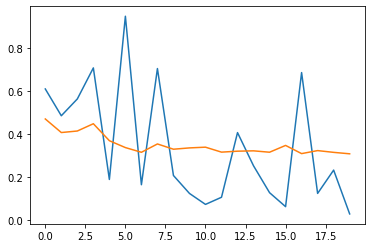

In [228]:
plt.plot(eps,t_loss)
plt.plot(eps,d_loss)
plt.show()

In [248]:
torch.save(net.state_dict(), 'sstcls_{}.dat'.format(ep))